In [28]:
from drug_gan.trials.drug_gan import (load_dataset, 
                    normalize_dataframe, 
                    build_individual_map, 
                    IndividualSequenceDataset, 
                    Generator, 
                    Discriminator, 
                    DATA_SOURCE,
                    MODEL_SAVE_PATH,
                    DEVICE, 
                    NOISE_DIM, 
                    GEN_HIDDEN_DIM, 
                    DISC_HIDDEN_DIM)

In [29]:
orig_df = load_dataset(DATA_SOURCE)
orig_df.head()


,ID,TIME,EF,AGE,A1,A2,A3,AL1,AL2,AL3,KEO,EO,EM,EC50,N,E,PRED,RES,WRES
0,1,0.0,18.85,30.58,0.097699,0.006491,0.00013,0.43415,0.057008,0.009551,0.56119,20.508,4.7678,9.0496,2.5286,20.508,19.975,-1.125300,-0.73137
1,1,0.5,19.91,30.58,0.097699,0.006491,0.00013,0.43415,0.057008,0.009551,0.56119,20.508,4.7678,9.0496,2.5286,20.500,19.971,-0.061008,-0.15100
2,1,1.0,19.51,30.58,0.097699,0.006491,0.00013,0.43415,0.057008,0.009551,0.56119,20.508,4.7678,9.0496,2.5286,20.332,19.893,-0.382520,-0.25709
3,1,1.5,18.67,30.58,0.097699,0.006491,0.00013,0.43415,0.057008,0.009551,0.56119,20.508,4.7678,9.0496,2.5286,19.620,19.585,-0.914520,-0.32364
4,1,2.0,19.03,30.58,0.097699,0.006491,0.00013,0.43415,0.057008,0.009551,0.56119,20.508,4.7678,9.0496,2.5286,18.150,18.949,0.080875,0.59570


In [30]:
df, stats = normalize_dataframe(orig_df.copy())
indiv_map = build_individual_map(df)
dataset = IndividualSequenceDataset(indiv_map)

G = Generator(NOISE_DIM, GEN_HIDDEN_DIM, dataset.max_length,
                dataset.feature_dim, dataset.feature_columns).to(DEVICE)
D = Discriminator(dataset.max_length, dataset.feature_dim, DISC_HIDDEN_DIM).to(DEVICE)

In [31]:
import torch
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
g_losses = checkpoint["g_losses"]
d_losses = checkpoint["d_losses"]

In [32]:


G.load_state_dict(checkpoint["G"])
D.load_state_dict(checkpoint["D"])
G.eval();

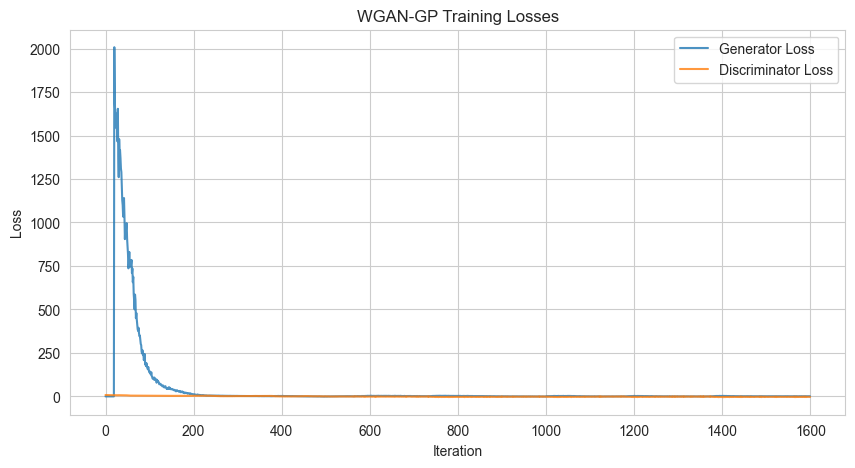

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss", alpha=0.8)
plt.plot(d_losses, label="Discriminator Loss", alpha=0.8)
plt.title("WGAN-GP Training Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

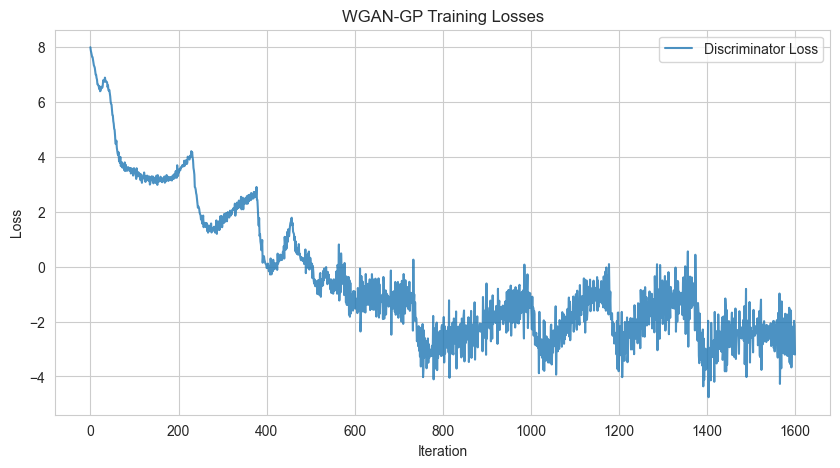

In [34]:

plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss", alpha=0.8)
plt.title("WGAN-GP Training Losses")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
import pandas as pd
G.to(DEVICE)

num_new_individuals = 2000
show_num_individuals = 5
z = torch.randn(num_new_individuals, NOISE_DIM, device=DEVICE)
with torch.no_grad():
    fake_data = G(z).cpu()

# Convert to Pandas and display top rows per individual
all_rows = []
for i in range(num_new_individuals):
    fake_df = pd.DataFrame(fake_data[i].numpy(), columns=dataset.feature_columns)
    fake_df.insert(0, "ID", i + 1000)  # assign new synthetic IDs
    all_rows.append(fake_df)

synthetic_df = pd.concat(all_rows, ignore_index=True)


In [36]:
import pickle
from pathlib import Path

In [37]:
stats_path = Path(MODEL_SAVE_PATH).with_suffix(".stats.pkl")
if stats_path.exists():
    with open(stats_path, "rb") as f:
        stats = pickle.load(f)
    print(f"Loaded normalization stats from {stats_path}")
else:
    print("⚠️ No stats file found — cannot denormalize properly.")
    stats = None

Loaded normalization stats from /Users/chandarl/Documents/GitHub/drug_gan/models/trained_wgan_gp.stats.pkl


In [38]:
if stats:
    for c, (mean, std) in stats.items():
        if c in synthetic_df.columns:
            synthetic_df[c] = synthetic_df[c] * std + mean

In [39]:
print("\nGenerated Data - Top 5 Rows for Each Individual")
print("=" * 80)
for i in range(show_num_individuals):
    sub = synthetic_df[synthetic_df["ID"] == 1000 + i].head(5)
    print(f"\nIndividual ID: {1000 + i} (Total rows: {dataset.max_length})")
    print("=" * 80)
    print(sub.to_string(index=False))


Generated Data - Top 5 Rows for Each Individual

Individual ID: 1000 (Total rows: 145)
  ID       TIME        EF       AGE       A1       A2       A3      AL1      AL2      AL3      KEO        EO      EM      EC50        N         E      PRED       RES      WRES
1000 -54.761574 20.528027 60.893913 0.145268 0.017057 0.000243 0.824407 0.100378 0.018032 0.347663 21.465523 6.30216 13.088764 2.834435 18.334351 14.090403 -1.913052 -0.197173
1000  -4.270586 14.768711 60.893913 0.145268 0.017057 0.000243 0.824407 0.100378 0.018032 0.347663 21.465523 6.30216 13.088764 2.834435 15.067250 10.914748  0.901293  0.024524
1000   7.205742 19.072147 60.893913 0.145268 0.017057 0.000243 0.824407 0.100378 0.018032 0.347663 21.465523 6.30216 13.088764 2.834435 15.391958 13.865903 14.991404 -0.140673
1000   6.517654 11.783106 60.893913 0.145268 0.017057 0.000243 0.824407 0.100378 0.018032 0.347663 21.465523 6.30216 13.088764 2.834435 13.488728  7.132423 11.511596  0.669969
1000 -16.897694 16.141075 60.893

In [40]:
# Descriptive statistics for the entire real dataset
print("=" * 80)
print("DESCRIPTIVE STATISTICS - ENTIRE DATASET")
print("=" * 80)
print(f"\nTotal number of rows: {len(orig_df)}")
print(f"Number of individuals: {orig_df['ID'].nunique()}")
print(f"Average rows per individual: {len(orig_df) / orig_df['ID'].nunique():.2f}")
print("\nColumn ranges and statistics:")
print("=" * 80)

# Show descriptive statistics for all columns
desc_stats = orig_df.describe()
display(desc_stats)

# Show min and max for each column
print("\n" + "=" * 80)
print("MINIMUM AND MAXIMUM VALUES FOR EACH COLUMN:")
print("=" * 80)
for col in orig_df.columns:
    if col != 'ID':
        print(f"{col:15s}: Min = {orig_df[col].min():12.6f}, Max = {orig_df[col].max():12.6f}, Range = {orig_df[col].max() - orig_df[col].min():12.6f}")

DESCRIPTIVE STATISTICS - ENTIRE DATASET

Total number of rows: 3989
Number of individuals: 61
Average rows per individual: 65.39

Column ranges and statistics:


,ID,TIME,EF,AGE,A1,A2,A3,AL1,AL2,AL3,KEO,EO,EM,EC50,N,E,PRED,RES,WRES
count,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000,3989.000000
mean,37.112810,21.131988,13.311306,54.856789,0.180676,0.020621,0.000293,0.843570,0.100683,0.012018,0.536137,20.572091,5.883951,11.624163,2.842091,13.318496,12.878895,0.432412,0.023103
std,17.081383,15.010643,6.393905,20.176750,0.064214,0.006447,0.000546,0.245232,0.017371,0.012834,0.447095,2.765079,1.658227,5.812874,1.725208,6.121860,5.726342,3.557303,1.036262
min,1.000000,0.000000,1.410000,20.000000,0.059153,0.006491,0.000030,0.430110,0.057008,0.002506,0.140010,13.860000,2.945600,3.477300,1.188600,3.339400,5.519400,-18.295000,-6.350600
25%,25.000000,9.000000,7.421300,33.000000,0.128060,0.015598,0.000053,0.656520,0.090920,0.004194,0.306990,18.837000,4.680400,7.779600,1.750000,7.452000,6.655300,-1.571400,-0.464530
50%,40.000000,19.000000,12.673000,59.000000,0.172520,0.019768,0.000079,0.819010,0.098791,0.006141,0.442810,20.469000,5.580900,9.709100,2.226700,12.856000,12.924000,0.291280,0.007131
75%,52.000000,31.000000,19.097000,72.000000,0.234980,0.024185,0.000157,1.025300,0.111620,0.012469,0.652120,22.018000,7.012500,15.117000,3.376200,19.222000,19.157000,2.482900,0.532960
max,61.000000,100.000000,28.840000,85.000000,0.314380,0.041004,0.003435,1.459600,0.155810,0.056608,4.398200,26.922000,11.447000,28.013000,10.240000,26.922000,19.975000,18.821000,6.425500



MINIMUM AND MAXIMUM VALUES FOR EACH COLUMN:
TIME           : Min =     0.000000, Max =   100.000000, Range =   100.000000
EF             : Min =     1.410000, Max =    28.840000, Range =    27.430000
AGE            : Min =    20.000000, Max =    85.000000, Range =    65.000000
A1             : Min =     0.059153, Max =     0.314380, Range =     0.255227
A2             : Min =     0.006491, Max =     0.041004, Range =     0.034513
A3             : Min =     0.000030, Max =     0.003435, Range =     0.003404
AL1            : Min =     0.430110, Max =     1.459600, Range =     1.029490
AL2            : Min =     0.057008, Max =     0.155810, Range =     0.098802
AL3            : Min =     0.002506, Max =     0.056608, Range =     0.054102
KEO            : Min =     0.140010, Max =     4.398200, Range =     4.258190
EO             : Min =    13.860000, Max =    26.922000, Range =    13.062000
EM             : Min =     2.945600, Max =    11.447000, Range =     8.501400
EC50           : Mi

In [41]:
# Descriptive statistics for the generateddataset
print("=" * 80)
print("DESCRIPTIVE STATISTICS - GENERATED DATASET")
print("=" * 80)
print(f"\nTotal number of rows: {len(synthetic_df)}")
print(f"Number of individuals: {synthetic_df['ID'].nunique()}")
print(f"Average rows per individual: {len(synthetic_df) / synthetic_df['ID'].nunique():.2f}")
print("\nColumn ranges and statistics:")
print("=" * 80)

# Show descriptive statistics for all columns
desc_stats = synthetic_df.describe()
display(desc_stats)

# Show min and max for each column
print("\n" + "=" * 80)
print("MINIMUM AND MAXIMUM VALUES FOR EACH COLUMN:")
print("=" * 80)
for col in synthetic_df.columns:
    if col != 'ID':
        print(f"{col:15s}: Min = {synthetic_df[col].min():12.6f}, Max = {synthetic_df[col].max():12.6f}, Range = {synthetic_df[col].max() - synthetic_df[col].min():12.6f}")

DESCRIPTIVE STATISTICS - GENERATED DATASET

Total number of rows: 290000
Number of individuals: 2000
Average rows per individual: 145.00

Column ranges and statistics:


,ID,TIME,EF,AGE,A1,A2,A3,AL1,AL2,AL3,KEO,EO,EM,EC50,N,E,PRED,RES,WRES
count,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000,290000.000000
mean,1999.500000,24.648737,13.829245,57.253944,0.186579,0.019731,0.000282,0.846484,0.100910,0.013318,0.516947,20.498215,5.944552,12.183800,2.718174,14.324319,13.425762,0.081349,-0.021162
std,577.351192,26.559725,10.203176,15.830784,0.057712,0.006083,0.000401,0.224940,0.013915,0.011254,0.292879,2.469007,1.434387,5.102448,1.304967,10.183525,9.502947,5.480940,1.459168
min,1000.000000,-105.123863,-18.959404,9.605373,0.077058,0.004782,-0.000089,0.303238,0.051816,0.000605,0.224485,11.009575,1.368011,-0.152972,-0.813506,-12.138556,-17.719376,-34.020584,-10.598208
25%,1499.750000,9.392838,8.454106,43.319453,0.143971,0.015119,0.000077,0.680154,0.092249,0.005040,0.343245,19.003970,4.928222,8.556446,1.808210,9.122945,7.928668,-2.360383,-0.495147
50%,1999.500000,21.657167,12.136400,61.246407,0.176648,0.018141,0.000124,0.791899,0.098771,0.009296,0.428506,20.697063,5.913618,11.102412,2.510891,12.738496,12.281856,0.163130,0.020132
75%,2499.250000,37.666718,17.445849,70.412252,0.223474,0.023858,0.000245,1.001008,0.108464,0.018445,0.567017,21.996318,6.904113,15.198729,3.326351,17.809896,17.504277,2.946065,0.587366
max,2999.000000,283.900452,179.817368,94.839157,0.390280,0.042758,0.003012,1.799031,0.164360,0.071443,2.643446,28.932442,10.703157,37.571228,9.170577,191.481277,166.780670,35.438126,9.319959



MINIMUM AND MAXIMUM VALUES FOR EACH COLUMN:
TIME           : Min =  -105.123863, Max =   283.900452, Range =   389.024323
EF             : Min =   -18.959404, Max =   179.817368, Range =   198.776764
AGE            : Min =     9.605373, Max =    94.839157, Range =    85.233780
A1             : Min =     0.077058, Max =     0.390280, Range =     0.313222
A2             : Min =     0.004782, Max =     0.042758, Range =     0.037976
A3             : Min =    -0.000089, Max =     0.003012, Range =     0.003101
AL1            : Min =     0.303238, Max =     1.799031, Range =     1.495793
AL2            : Min =     0.051816, Max =     0.164360, Range =     0.112544
AL3            : Min =     0.000605, Max =     0.071443, Range =     0.070838
KEO            : Min =     0.224485, Max =     2.643446, Range =     2.418962
EO             : Min =    11.009575, Max =    28.932442, Range =    17.922867
EM             : Min =     1.368011, Max =    10.703157, Range =     9.335147
EC50           : Mi

In [42]:
# ============================================================================
# DISTRIBUTION COMPARISON: Original vs Generated Data
# ============================================================================
# This cell provides both quantitative metrics and visual comparisons
# to assess how well the generated data matches the original distribution

import numpy as np
from scipy import stats
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Get feature columns (excluding ID)
feature_cols = [col for col in orig_df.columns if col != 'ID']

print("=" * 80)
print("QUANTITATIVE DISTRIBUTION COMPARISON")
print("=" * 80)


QUANTITATIVE DISTRIBUTION COMPARISON


In [43]:

# 1. Statistical Summary Comparison
print("\n1. MEAN AND STD COMPARISON")
print("-" * 80)
comparison_stats = pd.DataFrame({
    'Original_Mean': orig_df[feature_cols].mean(),
    'Generated_Mean': synthetic_df[feature_cols].mean(),
    'Mean_Diff': synthetic_df[feature_cols].mean() - orig_df[feature_cols].mean(),
    'Mean_Diff_Pct': ((synthetic_df[feature_cols].mean() - orig_df[feature_cols].mean()) / 
                      orig_df[feature_cols].mean() * 100),
    'Original_Std': orig_df[feature_cols].std(),
    'Generated_Std': synthetic_df[feature_cols].std(),
    'Std_Diff': synthetic_df[feature_cols].std() - orig_df[feature_cols].std(),
    'Std_Diff_Pct': ((synthetic_df[feature_cols].std() - orig_df[feature_cols].std()) / 
                     orig_df[feature_cols].std() * 100)
})
print(comparison_stats.round(2))



1. MEAN AND STD COMPARISON
--------------------------------------------------------------------------------
      Original_Mean  Generated_Mean  Mean_Diff  Mean_Diff_Pct  Original_Std  \
TIME          21.13           24.65       3.52          16.64         15.01   
EF            13.31           13.83       0.52           3.89          6.39   
AGE           54.86           57.25       2.40           4.37         20.18   
A1             0.18            0.19       0.01           3.27          0.06   
A2             0.02            0.02      -0.00          -4.32          0.01   
A3             0.00            0.00      -0.00          -3.92          0.00   
AL1            0.84            0.85       0.00           0.35          0.25   
AL2            0.10            0.10       0.00           0.22          0.02   
AL3            0.01            0.01       0.00          10.82          0.01   
KEO            0.54            0.52      -0.02          -3.58          0.45   
EO            20.57   

In [44]:

# 2. Kolmogorov-Smirnov Test (tests if two samples come from the same distribution)
print("\n2. KOLMOGOROV-SMIRNOV TEST (KS Statistic and p-value)")
print("-" * 80)
print("KS Statistic ranges from 0 to 1. Lower values indicate more similar distributions.")
print("p-value < 0.05 suggests distributions are significantly different.\n")

ks_results = []
for col in feature_cols:
    ks_stat, p_value = stats.ks_2samp(orig_df[col].dropna(), synthetic_df[col].dropna())
    ks_results.append({
        'Feature': col,
        'KS_Statistic': ks_stat,
        'p_value': p_value,
        'Similar': 'Yes' if p_value > 0.05 else 'No'
    })

ks_df = pd.DataFrame(ks_results)
print(ks_df.to_string(index=False))



2. KOLMOGOROV-SMIRNOV TEST (KS Statistic and p-value)
--------------------------------------------------------------------------------
KS Statistic ranges from 0 to 1. Lower values indicate more similar distributions.
p-value < 0.05 suggests distributions are significantly different.

Feature  KS_Statistic       p_value Similar
   TIME      0.111439  5.102787e-43      No
     EF      0.102291  2.672161e-36      No
    AGE      0.181955 1.769899e-114      No
     A1      0.153490  2.046827e-81      No
     A2      0.134026  4.189565e-62      No
     A3      0.255124 2.744715e-226      No
    AL1      0.100846  2.721262e-35      No
    AL2      0.105922  6.750178e-39      No
    AL3      0.248652 8.235107e-215      No
    KEO      0.206879 3.482154e-148      No
     EO      0.075486  6.021185e-20      No
     EM      0.131880  3.877187e-60      No
   EC50      0.161038  1.268858e-89      No
      N      0.134902  6.457287e-63      No
      E      0.141777  1.784744e-69      No
   PRED  

In [45]:

# 3. Wasserstein Distance (Earth Mover's Distance)
print("\n3. WASSERSTEIN DISTANCE (Earth Mover's Distance)")
print("-" * 80)
print("Lower values indicate more similar distributions.\n")

wasserstein_results = []
for col in feature_cols:
    orig_vals = orig_df[col].dropna().values
    synth_vals = synthetic_df[col].dropna().values
    wd = wasserstein_distance(orig_vals, synth_vals)
    # Normalize by the range of original data for interpretability
    orig_range = orig_vals.max() - orig_vals.min()
    normalized_wd = wd / orig_range if orig_range > 0 else wd
    wasserstein_results.append({
        'Feature': col,
        'Wasserstein_Distance': wd,
        'Normalized_WD': normalized_wd
    })

wd_df = pd.DataFrame(wasserstein_results)
print(wd_df.to_string(index=False))



3. WASSERSTEIN DISTANCE (Earth Mover's Distance)
--------------------------------------------------------------------------------
Lower values indicate more similar distributions.

Feature  Wasserstein_Distance  Normalized_WD
   TIME              6.144917       0.061449
     EF              1.661382       0.060568
    AGE              4.395158       0.067618
     A1              0.010084       0.039510
     A2              0.001058       0.030654
     A3              0.000085       0.025109
    AL1              0.033518       0.032558
    AL2              0.002714       0.027469
    AL3              0.002935       0.054248
    KEO              0.070002       0.016439
     EO              0.305616       0.023397
     EM              0.268734       0.031611
   EC50              1.009042       0.041125
      N              0.310303       0.034282
      E              1.774086       0.075229
   PRED              1.854229       0.128271
    RES              1.291399       0.034794
   WRES 

In [46]:

# 4. Correlation Comparison
print("\n4. CORRELATION MATRIX COMPARISON")
print("-" * 80)
orig_corr = orig_df[feature_cols].corr()
synth_corr = synthetic_df[feature_cols].corr()

# Calculate correlation difference
corr_diff = np.abs(orig_corr - synth_corr)
print(f"Mean absolute correlation difference: {corr_diff.values[np.triu_indices_from(corr_diff.values, k=1)].mean():.4f}")
print(f"Max absolute correlation difference: {corr_diff.values[np.triu_indices_from(corr_diff.values, k=1)].max():.4f}")

print("\n" + "=" * 80)
print("QUANTITATIVE SUMMARY")
print("=" * 80)
print(f"Average KS Statistic: {ks_df['KS_Statistic'].mean():.4f}")
print(f"Features with similar distributions (p > 0.05): {ks_df['Similar'].value_counts().get('Yes', 0)}/{len(ks_df)}")
print(f"Average Normalized Wasserstein Distance: {wd_df['Normalized_WD'].mean():.4f}")
print("=" * 80)



4. CORRELATION MATRIX COMPARISON
--------------------------------------------------------------------------------
Mean absolute correlation difference: 0.3242
Max absolute correlation difference: 1.2796

QUANTITATIVE SUMMARY
Average KS Statistic: 0.1401
Features with similar distributions (p > 0.05): 0/18
Average Normalized Wasserstein Distance: 0.0446


VISUAL COMPARISON: Histograms


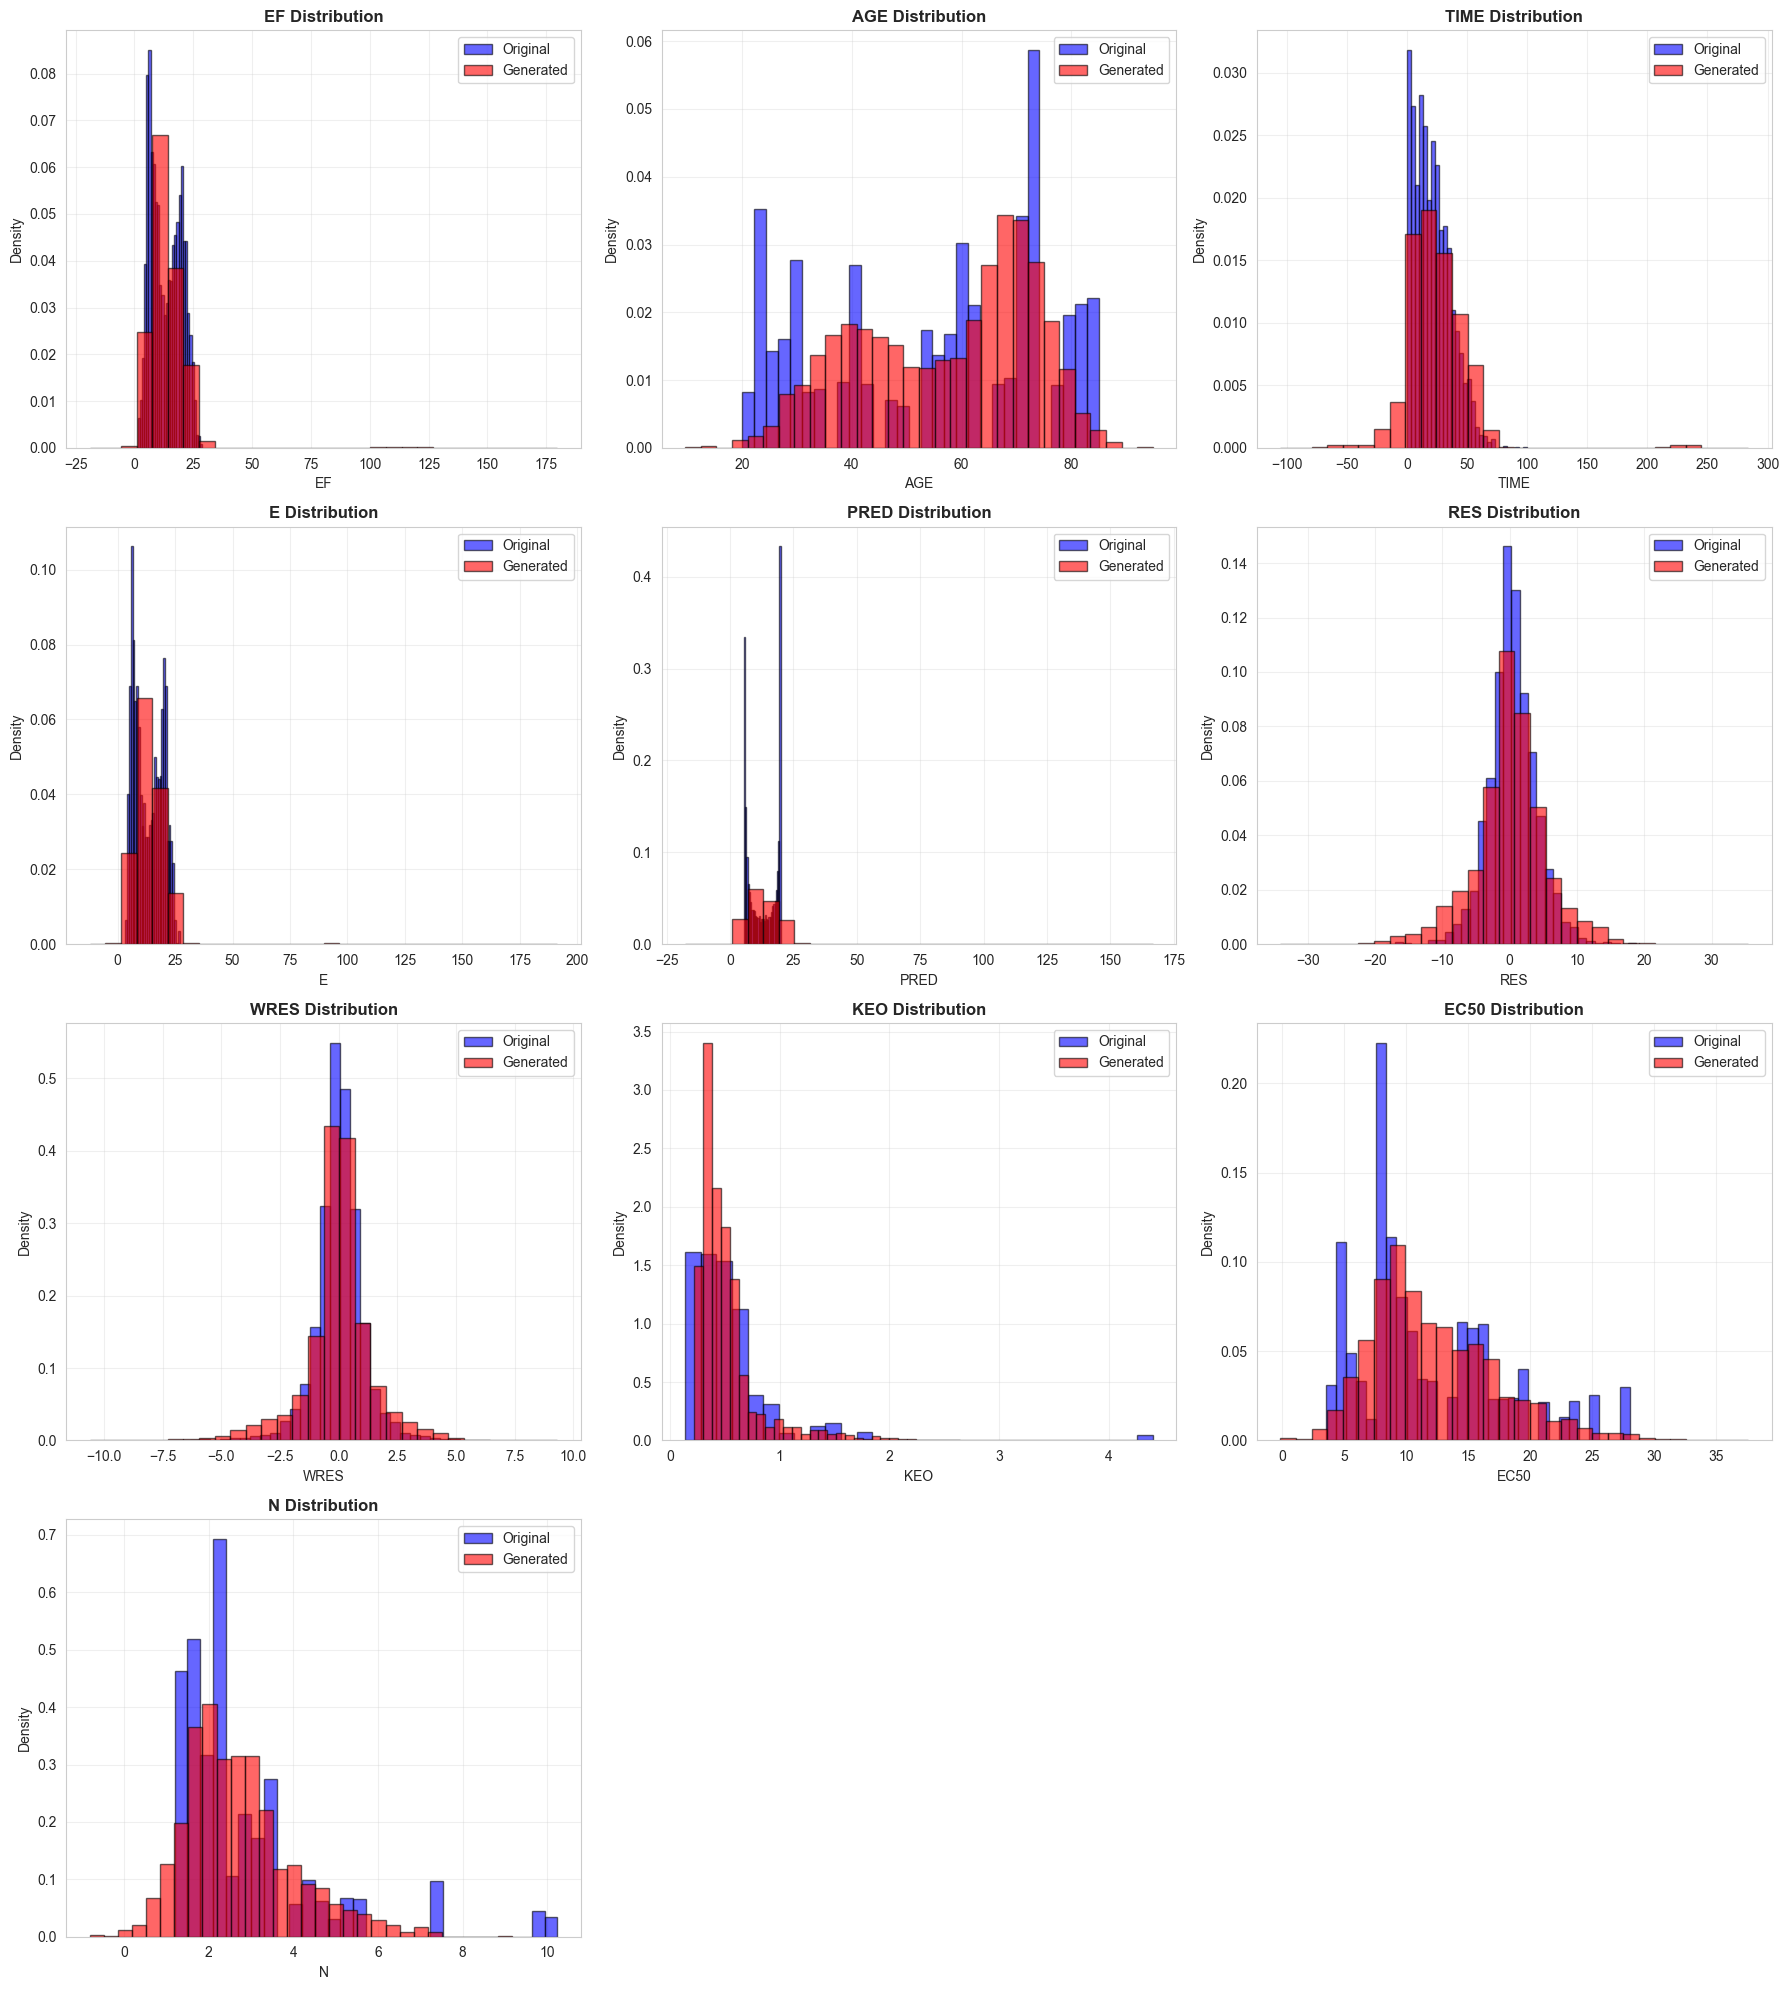

In [47]:
# ============================================================================
# VISUAL DISTRIBUTION COMPARISON
# ============================================================================

# Select a subset of key features for visualization (to avoid too many plots)
# You can modify this list to focus on specific features
key_features = ['EF', 'AGE', 'TIME', 'E', 'PRED', 'RES', 'WRES', 'KEO', 'EC50', 'N']

# Filter to only include features that exist in both datasets
key_features = [f for f in key_features if f in feature_cols]

# 1. Histogram Comparison for Key Features
print("=" * 80)
print("VISUAL COMPARISON: Histograms")
print("=" * 80)

n_features = len(key_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    
    # Plot histograms
    ax.hist(orig_df[feature].dropna(), bins=30, alpha=0.6, label='Original', 
            color='blue', density=True, edgecolor='black')
    ax.hist(synthetic_df[feature].dropna(), bins=30, alpha=0.6, label='Generated', 
            color='red', density=True, edgecolor='black')
    
    ax.set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



VISUAL COMPARISON: Q-Q Plots
Q-Q plots show if two distributions are similar. Points should lie along the diagonal line.



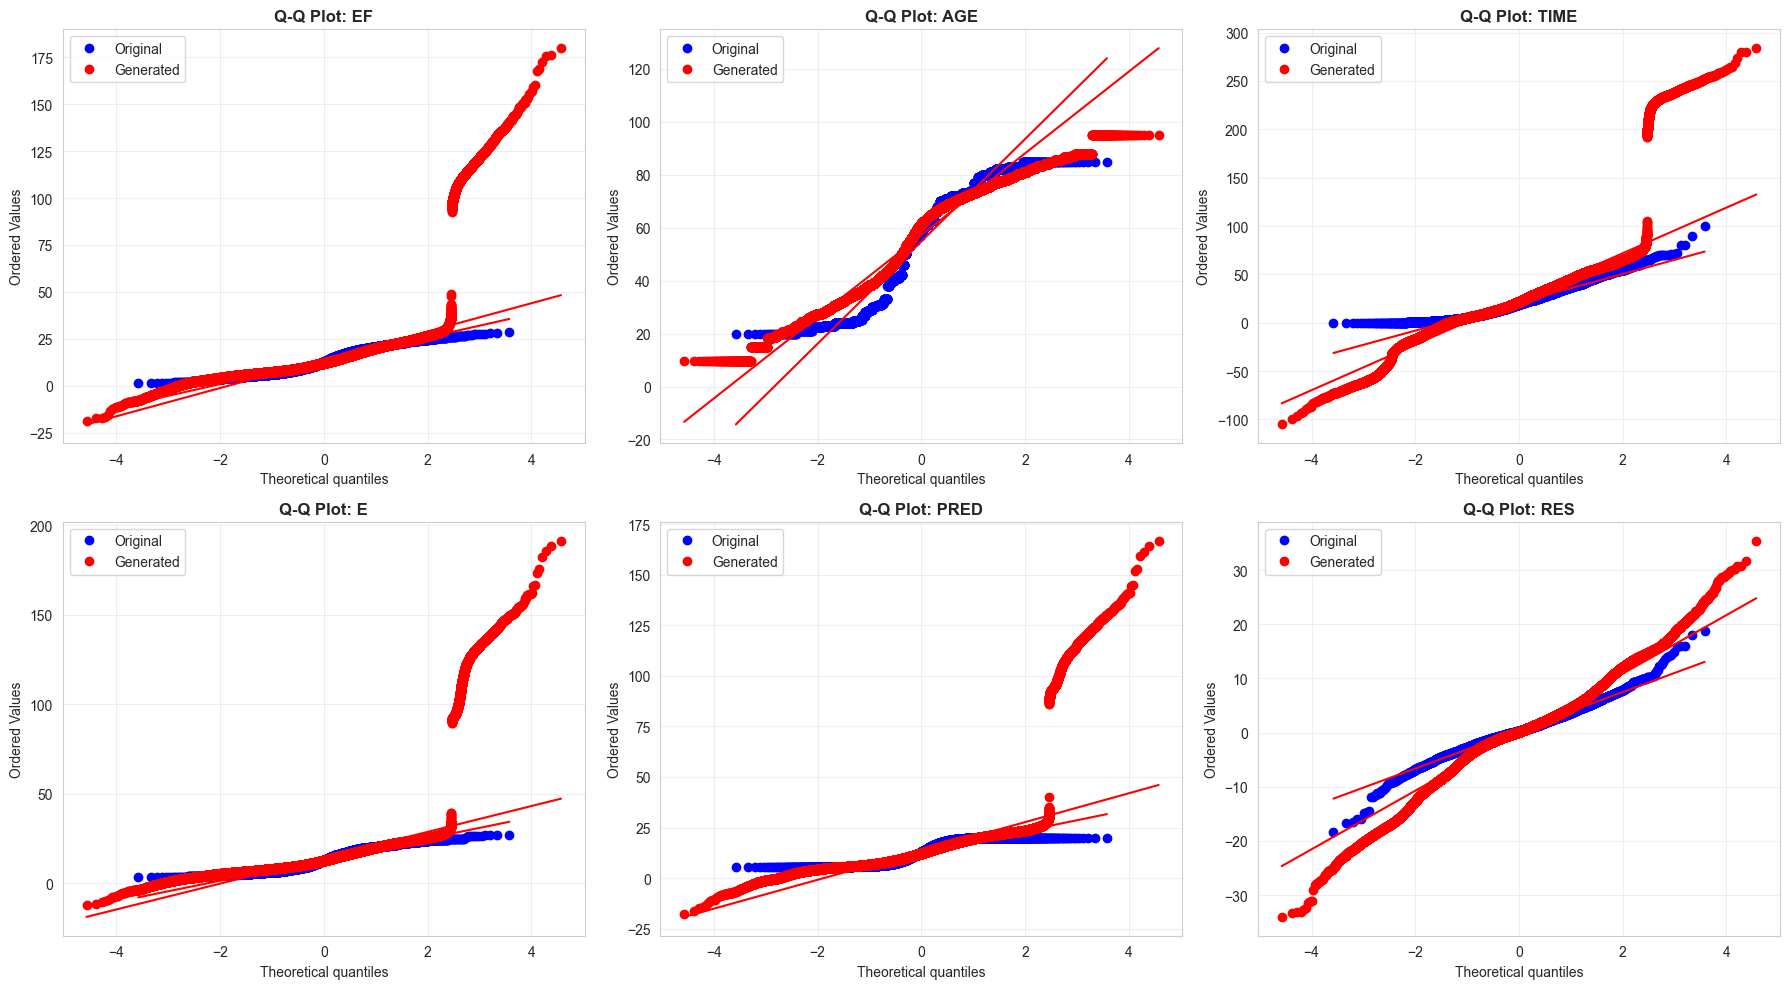

In [48]:

# 2. Q-Q Plots (Quantile-Quantile plots) for selected features
print("\n" + "=" * 80)
print("VISUAL COMPARISON: Q-Q Plots")
print("=" * 80)
print("Q-Q plots show if two distributions are similar. Points should lie along the diagonal line.\n")

n_features_qq = min(6, len(key_features))  # Show up to 6 Q-Q plots
n_cols_qq = 3
n_rows_qq = (n_features_qq + n_cols_qq - 1) // n_cols_qq

fig, axes = plt.subplots(n_rows_qq, n_cols_qq, figsize=(18, 5*n_rows_qq))
axes = axes.flatten() if n_features_qq > 1 else [axes]

for idx, feature in enumerate(key_features[:n_features_qq]):
    ax = axes[idx]
    
    orig_vals = orig_df[feature].dropna().values
    synth_vals = synthetic_df[feature].dropna().values
    
    # Create Q-Q plot
    stats.probplot(orig_vals, dist="norm", plot=ax)
    ax.get_lines()[0].set_markerfacecolor('blue')
    ax.get_lines()[0].set_markeredgecolor('blue')
    ax.get_lines()[0].set_label('Original')
    
    # Overlay generated data
    stats.probplot(synth_vals, dist="norm", plot=ax)
    ax.get_lines()[2].set_markerfacecolor('red')
    ax.get_lines()[2].set_markeredgecolor('red')
    ax.get_lines()[2].set_label('Generated')
    
    ax.set_title(f'Q-Q Plot: {feature}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_features_qq, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



VISUAL COMPARISON: Box Plots


/var/folders/_9/y2t92xh52qvclr5rtm7rgdwm0000gn/T/ipykernel_27849/2091239324.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Original', 'Generated'], patch_artist=True)
/var/folders/_9/y2t92xh52qvclr5rtm7rgdwm0000gn/T/ipykernel_27849/2091239324.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Original', 'Generated'], patch_artist=True)
/var/folders/_9/y2t92xh52qvclr5rtm7rgdwm0000gn/T/ipykernel_27849/2091239324.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Original', 'Generated'], patch_ar

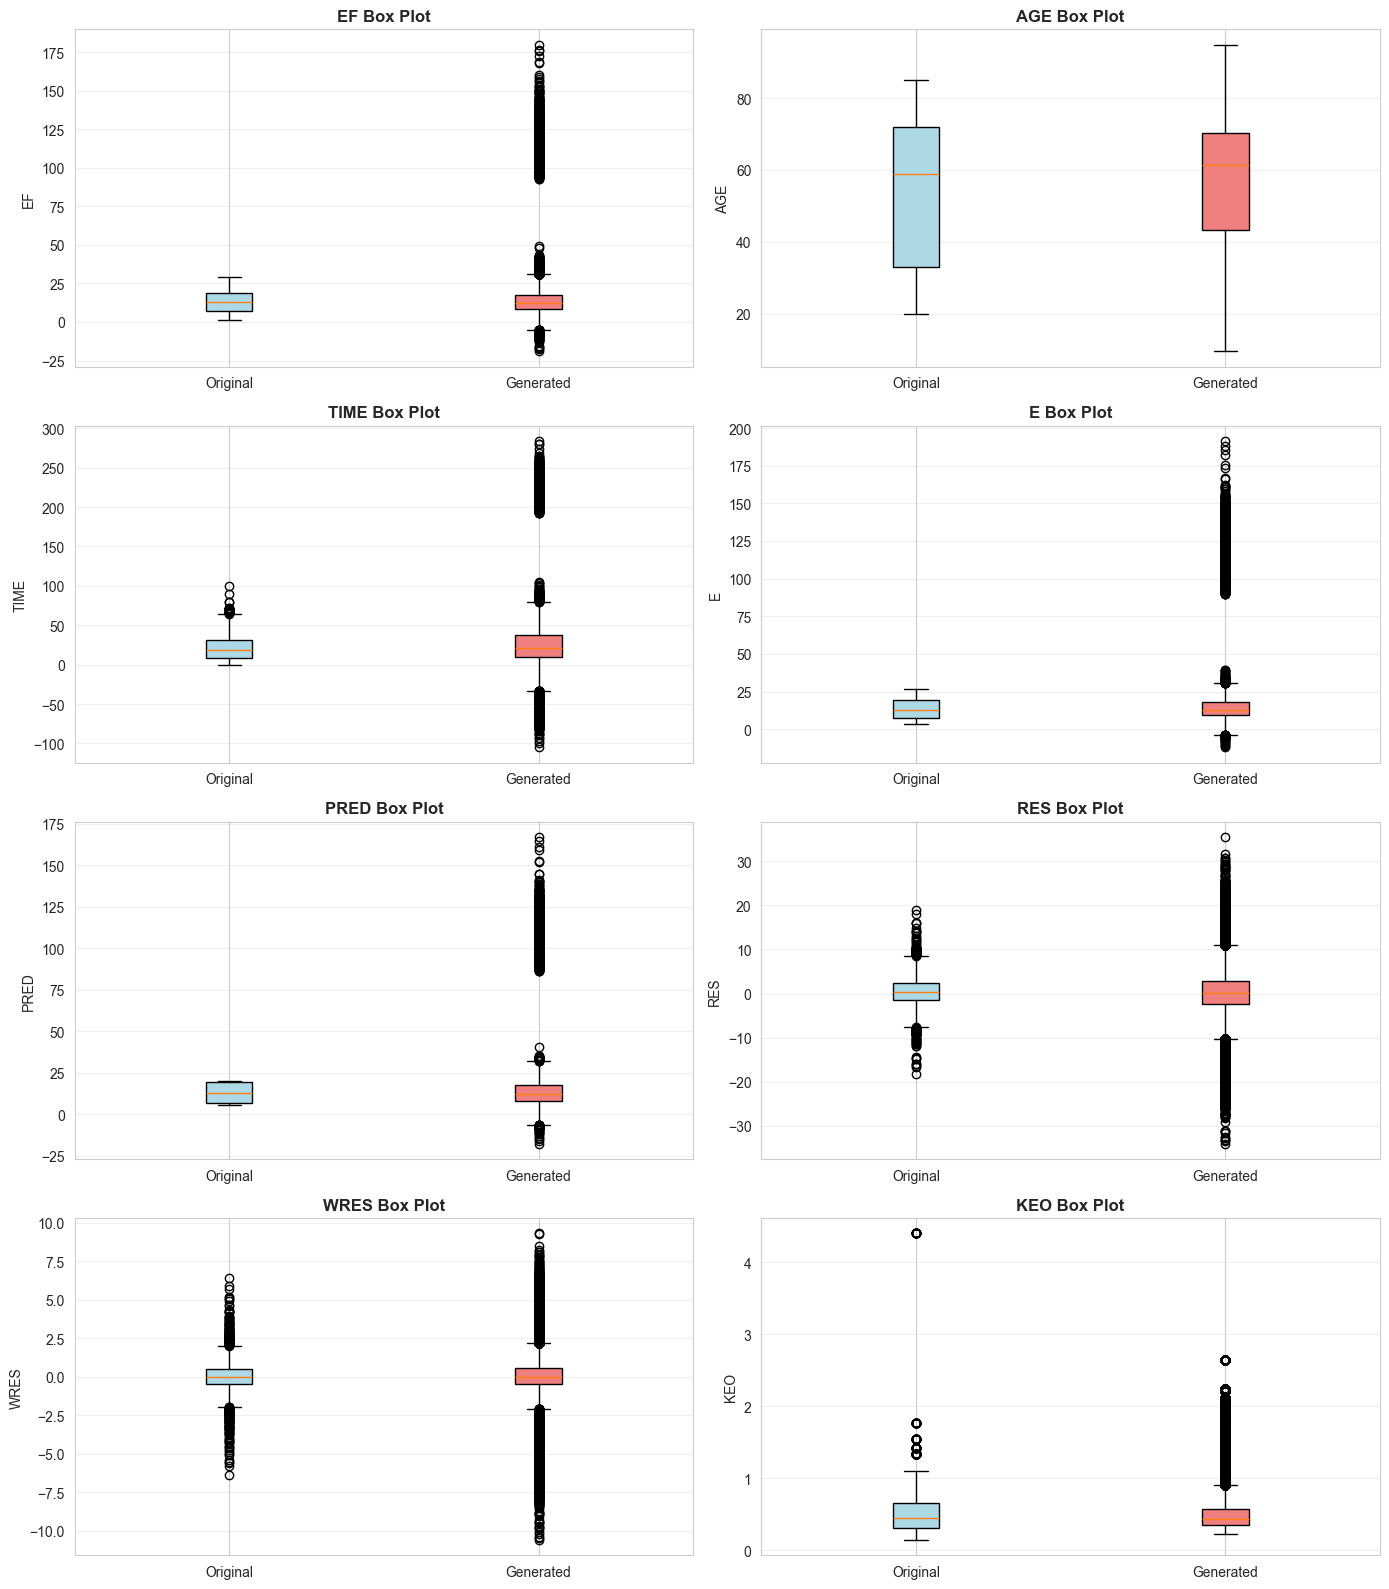

In [49]:

# 3. Box Plot Comparison
print("\n" + "=" * 80)
print("VISUAL COMPARISON: Box Plots")
print("=" * 80)

n_features_box = min(8, len(key_features))
n_cols_box = 2
n_rows_box = (n_features_box + n_cols_box - 1) // n_cols_box

fig, axes = plt.subplots(n_rows_box, n_cols_box, figsize=(14, 4*n_rows_box))
axes = axes.flatten() if n_features_box > 1 else [axes]

for idx, feature in enumerate(key_features[:n_features_box]):
    ax = axes[idx]
    
    data_to_plot = [orig_df[feature].dropna().values, synthetic_df[feature].dropna().values]
    bp = ax.boxplot(data_to_plot, labels=['Original', 'Generated'], patch_artist=True)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_title(f'{feature} Box Plot', fontsize=12, fontweight='bold')
    ax.set_ylabel(feature)
    ax.grid(True, alpha=0.3, axis='y')

# Hide extra subplots
for idx in range(n_features_box, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()



VISUAL COMPARISON: Correlation Matrices


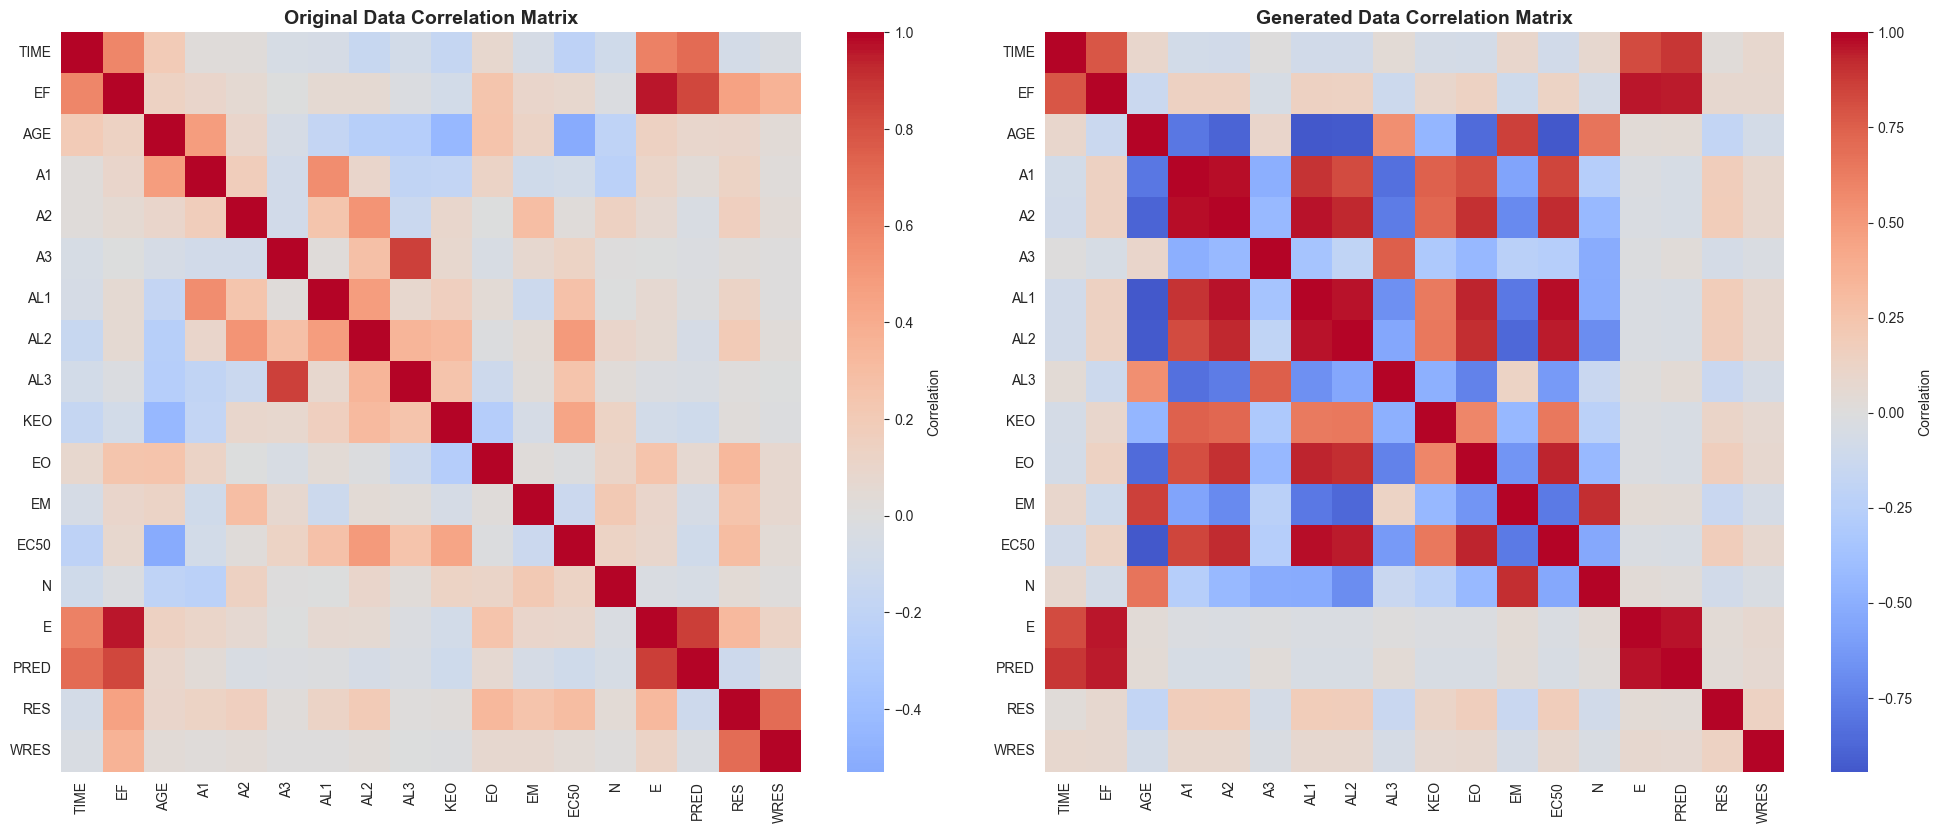

In [50]:

# 4. Correlation Heatmap Comparison
print("\n" + "=" * 80)
print("VISUAL COMPARISON: Correlation Matrices")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Original correlation
sns.heatmap(orig_corr, annot=False, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Original Data Correlation Matrix', fontsize=14, fontweight='bold')

# Generated correlation
sns.heatmap(synth_corr, annot=False, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Generated Data Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


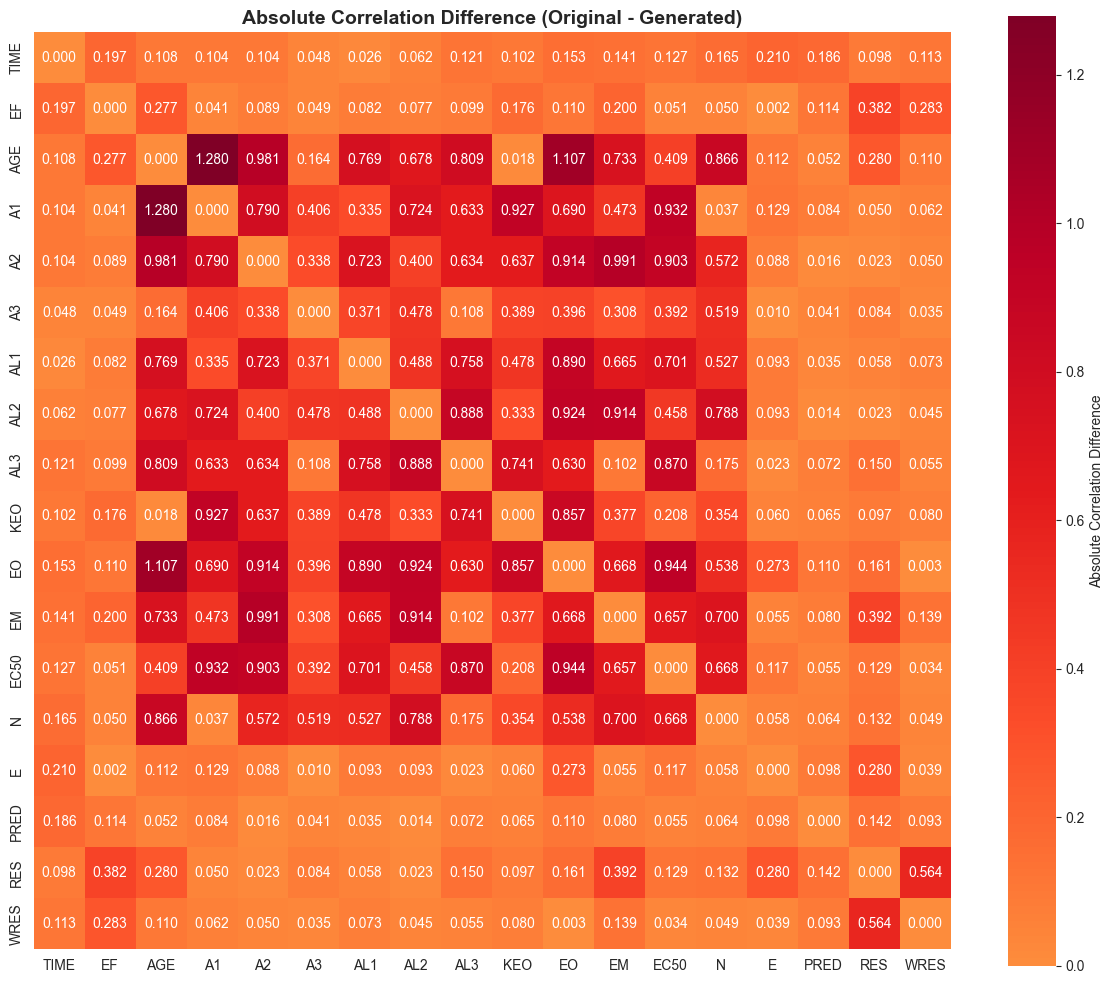

In [51]:

# Correlation difference heatmap
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(corr_diff, annot=True, cmap='YlOrRd', center=0, 
            square=True, fmt='.3f', ax=ax, cbar_kws={'label': 'Absolute Correlation Difference'})
ax.set_title('Absolute Correlation Difference (Original - Generated)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



VISUAL COMPARISON: Time Series (averaged across individuals)


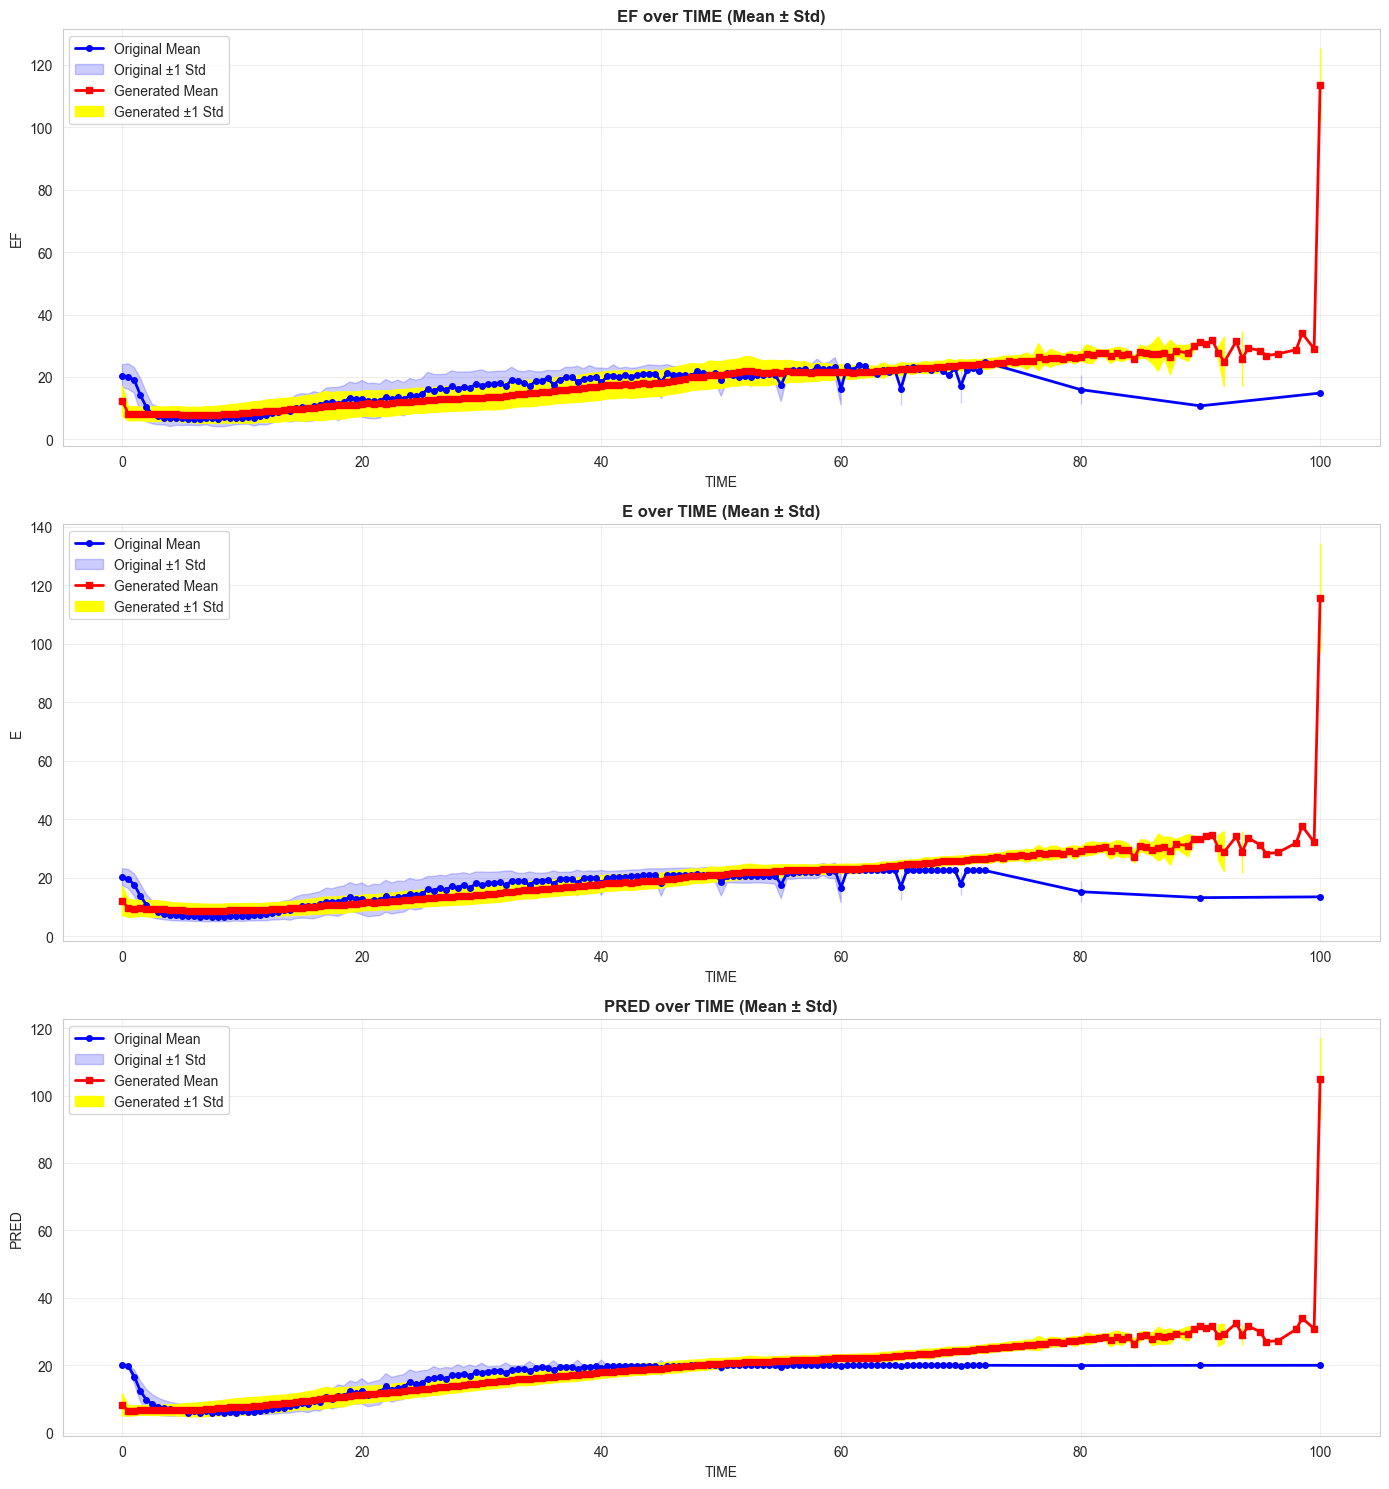

In [52]:

# 5. Time Series Comparison (for a few key features over TIME)
print("\n" + "=" * 80)
print("VISUAL COMPARISON: Time Series (averaged across individuals)")
print("=" * 80)

if 'TIME' in feature_cols:
    time_features = ['EF', 'E', 'PRED']  # Features that vary over time
    time_features = [f for f in time_features if f in feature_cols]
    
    if time_features:
        n_time_features = len(time_features)
        fig, axes = plt.subplots(n_time_features, 1, figsize=(14, 5*n_time_features))
        if n_time_features == 1:
            axes = [axes]
        
        # Round synthetic TIME to nearest 0.5, set negative times to 0, and cap at 100 (once before loop)
        synthetic_df_copy = synthetic_df.copy()
        synthetic_df_copy['TIME_ROUNDED'] = np.round(synthetic_df_copy['TIME'] * 2) / 2
        synthetic_df_copy['TIME_ROUNDED'] = np.maximum(synthetic_df_copy['TIME_ROUNDED'], 0)
        synthetic_df_copy['TIME_ROUNDED'] = np.minimum(synthetic_df_copy['TIME_ROUNDED'], 100)
        
        for idx, feature in enumerate(time_features):
            ax = axes[idx]
            
            # Group by TIME and calculate mean for original data
            orig_time_mean = orig_df.groupby('TIME')[feature].mean().reset_index()
            orig_time_std = orig_df.groupby('TIME')[feature].std().reset_index()
            
            # Group by rounded TIME and calculate mean for generated data
            synth_time_mean = synthetic_df_copy.groupby('TIME_ROUNDED')[feature].mean().reset_index()
            synth_time_mean = synth_time_mean.rename(columns={'TIME_ROUNDED': 'TIME'})
            synth_time_std = synthetic_df_copy.groupby('TIME_ROUNDED')[feature].std().reset_index()
            synth_time_std = synth_time_std.rename(columns={'TIME_ROUNDED': 'TIME'})
            
            # Plot with error bars (std)
            ax.plot(orig_time_mean['TIME'], orig_time_mean[feature], 
                   'o-', label='Original Mean', color='blue', linewidth=2, markersize=4)
            ax.fill_between(orig_time_mean['TIME'], 
                           orig_time_mean[feature] - orig_time_std[feature],
                           orig_time_mean[feature] + orig_time_std[feature],
                           alpha=0.2, color='blue', label='Original ±1 Std')
            
            ax.plot(synth_time_mean['TIME'], synth_time_mean[feature], 
                   's-', label='Generated Mean', color='red', linewidth=2, markersize=4, alpha=1)
            ax.fill_between(synth_time_mean['TIME'], 
                           synth_time_mean[feature] - synth_time_std[feature],
                           synth_time_mean[feature] + synth_time_std[feature],
                           alpha=1, color='yellow', label='Generated ±1 Std')
            
            ax.set_xlabel('TIME')
            ax.set_ylabel(feature)
            ax.set_title(f'{feature} over TIME (Mean ± Std)', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()



VISUAL ORIG DATA: Time Series (averaged across individuals)


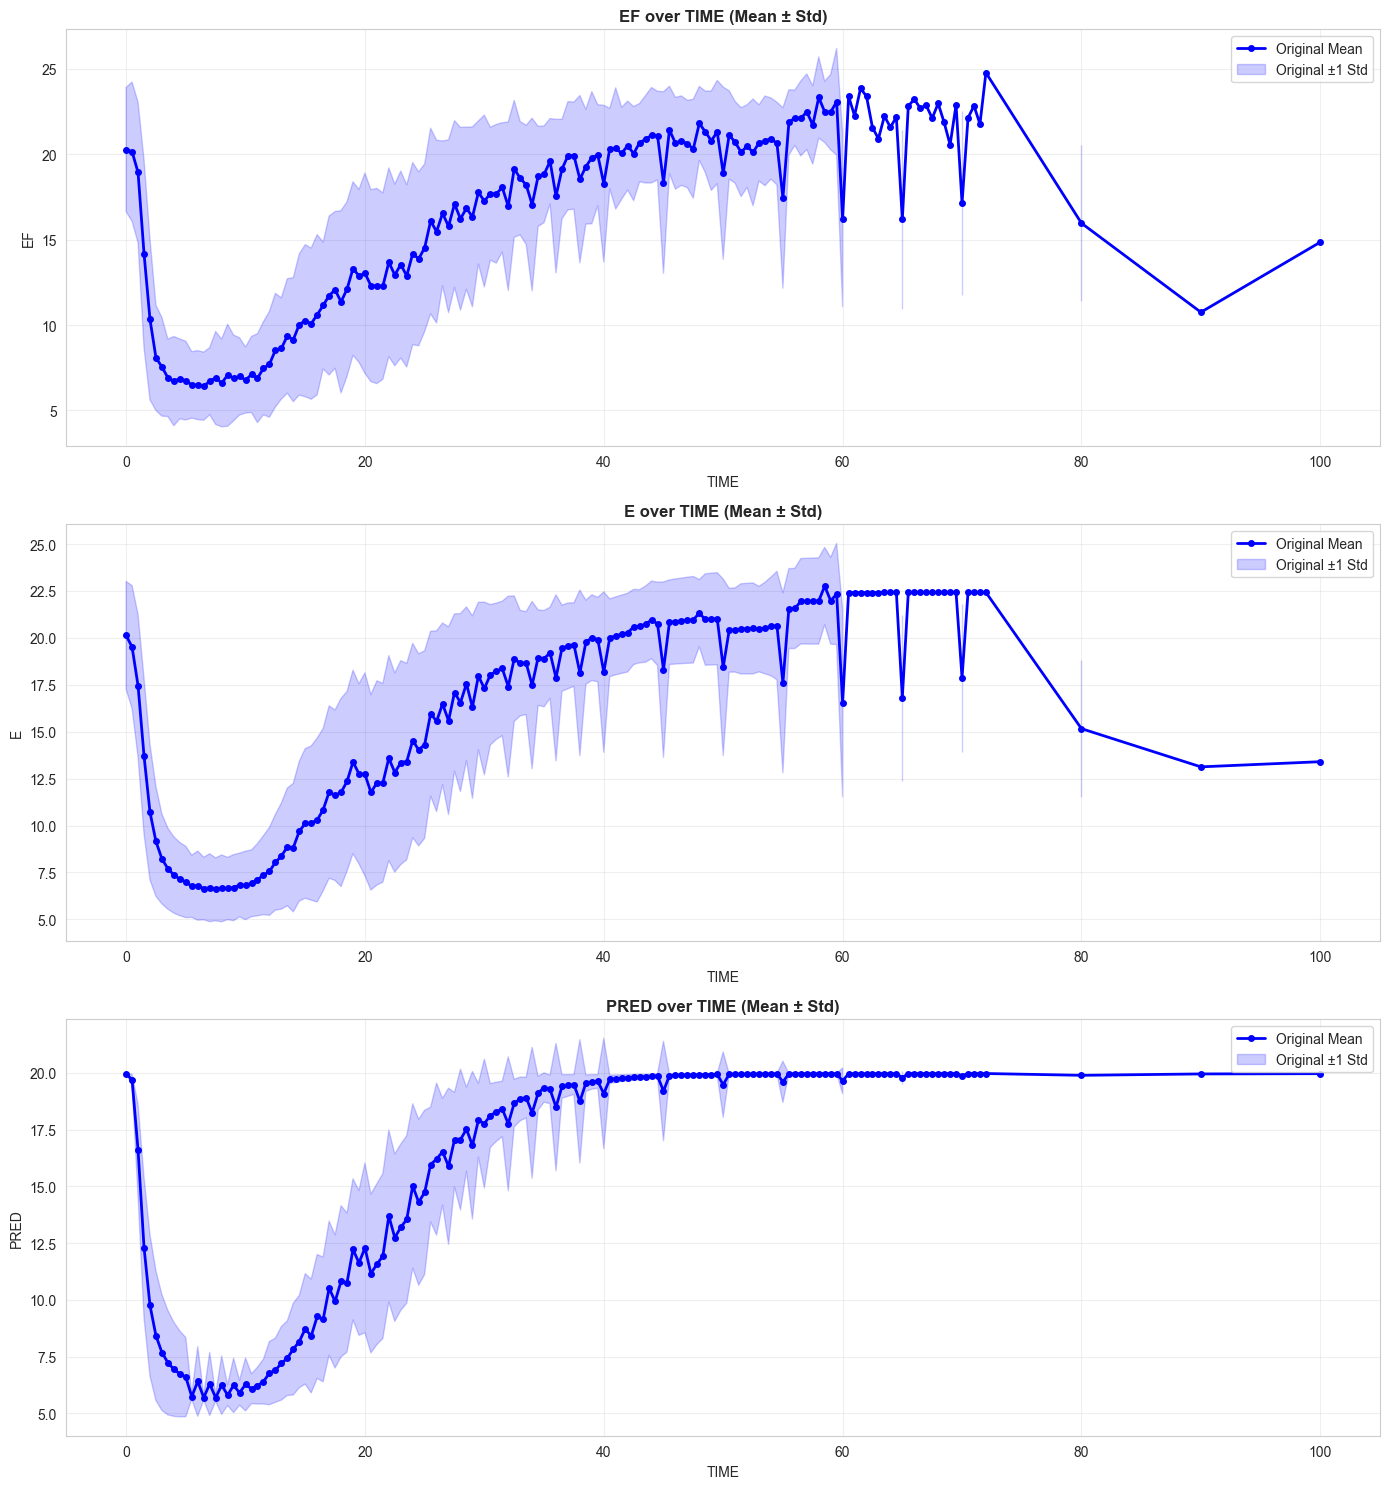

In [53]:

# 6. Time Series of original data alone
print("\n" + "=" * 80)
print("VISUAL ORIG DATA: Time Series (averaged across individuals)")
print("=" * 80)

if 'TIME' in feature_cols:
    time_features = ['EF', 'E', 'PRED']  # Features that vary over time
    time_features = [f for f in time_features if f in feature_cols]
    
    if time_features:
        n_time_features = len(time_features)
        fig, axes = plt.subplots(n_time_features, 1, figsize=(14, 5*n_time_features))
        if n_time_features == 1:
            axes = [axes]
        
        # Round synthetic TIME to nearest 0.5, set negative times to 0, and cap at 100 (once before loop)
        synthetic_df_copy = synthetic_df.copy()
        synthetic_df_copy['TIME_ROUNDED'] = np.round(synthetic_df_copy['TIME'] * 2) / 2
        synthetic_df_copy['TIME_ROUNDED'] = np.maximum(synthetic_df_copy['TIME_ROUNDED'], 0)
        synthetic_df_copy['TIME_ROUNDED'] = np.minimum(synthetic_df_copy['TIME_ROUNDED'], 100)
        
        for idx, feature in enumerate(time_features):
            ax = axes[idx]
            
            # Group by TIME and calculate mean for original data
            orig_time_mean = orig_df.groupby('TIME')[feature].mean().reset_index()
            orig_time_std = orig_df.groupby('TIME')[feature].std().reset_index()
            
            # Group by rounded TIME and calculate mean for generated data
            synth_time_mean = synthetic_df_copy.groupby('TIME_ROUNDED')[feature].mean().reset_index()
            synth_time_mean = synth_time_mean.rename(columns={'TIME_ROUNDED': 'TIME'})
            synth_time_std = synthetic_df_copy.groupby('TIME_ROUNDED')[feature].std().reset_index()
            synth_time_std = synth_time_std.rename(columns={'TIME_ROUNDED': 'TIME'})
            
            # Plot with error bars (std)
            ax.plot(orig_time_mean['TIME'], orig_time_mean[feature], 
                   'o-', label='Original Mean', color='blue', linewidth=2, markersize=4)
            ax.fill_between(orig_time_mean['TIME'], 
                           orig_time_mean[feature] - orig_time_std[feature],
                           orig_time_mean[feature] + orig_time_std[feature],
                           alpha=0.2, color='blue', label='Original ±1 Std')
            
            ax.set_xlabel('TIME')
            ax.set_ylabel(feature)
            ax.set_title(f'{feature} over TIME (Mean ± Std)', fontsize=12, fontweight='bold')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


In [54]:

print("\n" + "=" * 80)
print("Visual comparison complete!")
print("=" * 80)



Visual comparison complete!
